# Compute the density of waves over the entire DUNEX experiment

In [1]:
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import netCDF4 as nc
import numpy as np
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
mission_list = glob.glob('../microSWIFT_data/final_dataset/mission_*.nc')
bathy_file = '../microSWIFT_data/FRFdata/' \
             'FRF_geomorphology_DEMs_surveyDEM_20211021.nc'

In [3]:
wave_x_locs_all = []
wave_y_locs_all = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                        y_locations,
                                                        eta, time,
                                                        bathy_file)

    indices = np.logical_not(np.logical_or(np.isnan(wave_x_locs),
                                            np.isnan(wave_y_locs)))     
    indices = np.array(indices)
    wave_x_locs = np.array(wave_x_locs)[indices]
    wave_y_locs = np.array(wave_y_locs)[indices]

    wave_x_locs_all.append(wave_x_locs)
    wave_y_locs_all.append(wave_y_locs)

wave_x_locs_all = np.concatenate(wave_x_locs_all).flatten()
wave_y_locs_all = np.concatenate(wave_y_locs_all).flatten()

print(f'Total Number of Waves Measured: {wave_x_locs_all.size}')

Total Number of Waves Measured: 114396


## Plot the density of all individual waves 

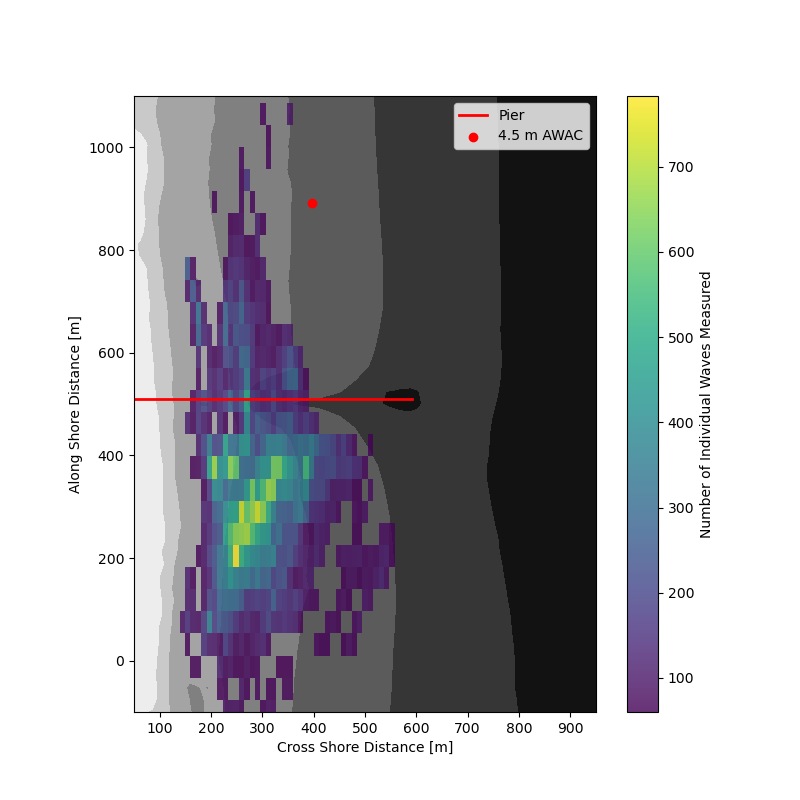

In [4]:
fig, ax = plt.subplots(figsize=(8,8))

bathy_dataset = nc.Dataset(bathy_file)
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],
                                    bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]
ax.contourf(xFRF_grid, yFRF_grid, bathy, cmap='gray')
h, _, _, map = ax.hist2d(wave_x_locs_all,
                wave_y_locs_all,
                bins=50, cmap='viridis', alpha=0.8, cmin=60)
cbar = fig.colorbar(map, ax=ax)
cbar.set_label('Number of Individual Waves Measured')
ax.plot([50,591],[510,510], linewidth=2, color='r', label='Pier') # coordinates of pier
awac4p5m_location = [397.35, 890.98] # Converted from lat lon locations 
                                     # published on FRF data portal
ax.scatter(awac4p5m_location[0],awac4p5m_location[1],
           color='r', label='4.5 m AWAC')

ax.set_xlim([np.min(xFRF_grid), np.max(xFRF_grid)])
ax.set_ylim([np.min(yFRF_grid), np.max(yFRF_grid)])
ax.set_xlabel('Cross Shore Distance [m]')
ax.set_ylabel('Along Shore Distance [m]')
ax.set_aspect('equal')
ax.legend()

bathy_dataset.close()